# Preprocessing and EDA

In [70]:
# Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 1. Basic cleaning

In [71]:
# Read data frame
data = pd.read_csv('strokedata.csv', encoding = 'utf-8')
data = data.drop('id', axis=1)  # drop id column

# Drop categories with very low observations
data = data[(data.gender=='Male')|(data.gender=='Female')]  # Gender = other
data = data[~(data.work_type=='Never_worked')] # Never worked


# Convert binary categorical variables to dummy variables
data['gender'] = np.where(data['gender'] == 'Male', 1, 0)
data['ever_married'] = np.where(data['ever_married'] == 'Yes', 1, 0)
data['Residence_type'] = np.where(data['Residence_type'] == 'Urban', 1, 0)

data = data.reindex(columns=['stroke'] + list(data.columns[:-1]))  # Move stroke to first column

# Replace nan by string
data.loc[data.smoking_status.isnull(), 'smoking_status'] = 'Unknown'

# Rename column
data = data.rename({'Residence_type':'urban_home'}, axis=1)

# Rename values
data.work_type = data.work_type.map({'Private':'private', 'Self-employed': 'self_emp', 'children':'child', 'Govt_job':'govt'})
data.smoking_status = data.smoking_status.map({'formerly smoked':'former', 'never smoked': 'never', 'smokes':'active', 'Unknown':'unknown'})

# Drop NAs
missing_bmi = sum(data.isnull().sum()[data.isnull().sum() > 0])
print('Dropping {:.0f} missing values in BMI: {:.1%}'.format(missing_bmi, missing_bmi/len(data)))
data = data.dropna().reset_index(drop=True)
missing_smoke = sum(data.smoking_status == 'unknown')
print('Converted {:.0f} smoking status to unknown: {:.1%}'.format(missing_smoke, missing_smoke/len(data)))
data.head(3)

Dropping 1457 missing values in BMI: 3.4%
Converted 12791 smoking status to unknown: 30.6%


,stroke,gender,age,hypertension,heart_disease,ever_married,work_type,urban_home,avg_glucose_level,bmi,smoking_status
0,0,1,3.0,0,0,0,child,0,95.12,18.0,unknown
1,0,1,58.0,1,0,1,private,1,87.96,39.2,never
2,0,0,8.0,0,0,0,private,1,110.89,17.6,unknown


## 2. Prepare data for modelling

In [72]:
# One hot encode categorical variables
data_onehot = pd.get_dummies(data, columns=['work_type', 'smoking_status'])
data_onehot.head(3)

,stroke,gender,age,hypertension,heart_disease,ever_married,urban_home,avg_glucose_level,bmi,work_type_child,work_type_govt,work_type_private,work_type_self_emp,smoking_status_active,smoking_status_former,smoking_status_never,smoking_status_unknown
0,0,1,3.0,0,0,0,0,95.12,18.0,1,0,0,0,0,0,0,1
1,0,1,58.0,1,0,1,1,87.96,39.2,0,0,1,0,0,0,1,0
2,0,0,8.0,0,0,0,1,110.89,17.6,0,0,1,0,0,0,0,1


In [73]:
# Split data into train and test
train, test = train_test_split(data_onehot, test_size=0.2, random_state=42)

# Save train and test data
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [74]:
# SMOTE Oversampling
sm = BorderlineSMOTE(random_state=42)
X_train_os, y_train_os = sm.fit_resample(train.drop('stroke', axis=1), train.stroke)

# Save oversampled data
X_train_os.to_csv('X_train_SMOTE.csv', index=False)
y_train_os.to_csv('y_train_SMOTE.csv', index=False)
print(y_train_os.sum()/len(y_train_os))

0.5


In [75]:
X_train = train.drop('stroke', axis=1)
X_test = test.drop('stroke', axis=1)

# Apply PCA to train and test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
pca = PCA(n_components=8)
pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('Exp. var per component: {}% \nTotal exp. var: {:.2%}'.format(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)))

X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

# Save transformed data
X_train_pca.to_csv('X_train_PCA.csv', index=False)
X_test_pca.to_csv('X_test_PCA.csv', index=False)



Exp. var per component: [0.21476948 0.10964001 0.09067098 0.07663742 0.07183039 0.06886061
 0.06246663 0.05978395]% 
Total exp. var: 75.47%


C:\Users\sdien\Anaconda3\envs\ML\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [76]:
X_train_os.shape

(65822, 16)

In [77]:
# Apply PCA to SMOTED train and test data
scaler = StandardScaler()
X_train_os = scaler.fit_transform(X_train_os)
pca = PCA(n_components=8)
pca = pca.fit(X_train_os)
X_train_os_pca = pca.transform(X_train_os)
X_test_os_pca = pca.transform(X_test)  # transform non-SMOTE test data
print('Exp. var per component: {}% \nTotal exp. var: {:.2%}'.format(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)))

X_train_os_pca = pd.DataFrame(X_train_os_pca)
X_test_os_pca = pd.DataFrame(X_test_os_pca)

# Save transformed data
X_train_os_pca.to_csv('X_train_SMOTE_PCA.csv', index=False)
X_test_os_pca.to_csv('X_test_SMOTE_PCA.csv', index=False)

C:\Users\sdien\Anaconda3\envs\ML\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Exp. var per component: [0.18295195 0.09718186 0.0864619  0.07813449 0.07309074 0.06759722
 0.06271358 0.06177566]% 
Total exp. var: 70.99%


## 3. Summary statistics and plots

In [78]:
sns.set(style="whitegrid")
# define variable types
cont_vars = data[['age', 'avg_glucose_level', 'bmi']]
binary_vars = data[['ever_married', 'urban_home', 'gender', 'hypertension', 'heart_disease']]
cat_vars = data[['smoking_status', 'work_type']]

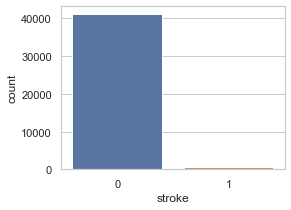

In [79]:
# Countplot of target variable
fig = plt.figure(figsize=(4,3))
sns.countplot(x='stroke', data=data)
plt.show()

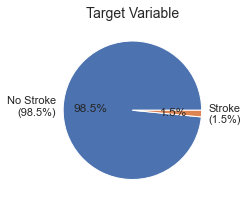

In [80]:
# Countplot of target variable
fig = plt.figure(figsize=(4,3))
plt.pie(x=data.stroke.value_counts(), labels=['No Stroke\n(98.5%)', 'Stroke\n(1.5%)'], autopct='%1.1f%%') # , explode=(0.1, 0)
plt.title('Target Variable', fontsize=14)
plt.tight_layout()
plt.savefig('plots/Target Variable.png')

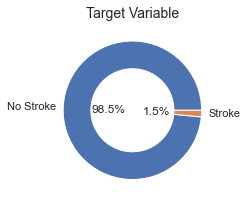

In [81]:
# Circle chart of target variable
fig = plt.figure(figsize=(4,3))
plt.pie(x=data.stroke.value_counts(), labels=['No Stroke', 'Stroke'], autopct='%1.1f%%',
        pctdistance=0.35) # , explode=(0.1, 0)
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
fig.gca().add_artist(centre_circle)
fig = plt.gcf()
plt.title('Target Variable', fontsize=14)
plt.tight_layout()
plt.savefig('plots/Target Variable Circle.png')

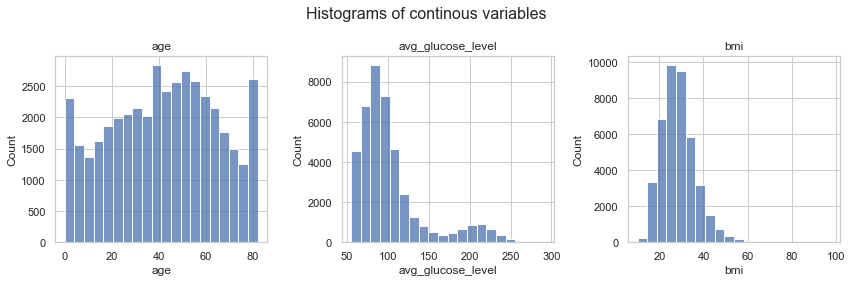

In [82]:
# plot histogram of all continous columns
fig, axs = plt.subplots(1, 3, figsize=(12,4))
for i, col in enumerate(cont_vars.columns):
    sns.histplot(ax=axs[i], x=col, data=data, bins=20)
    axs[i].set_title(col)
fig.suptitle('Histograms of continous variables', fontsize=16)
plt.tight_layout()
plt.show()

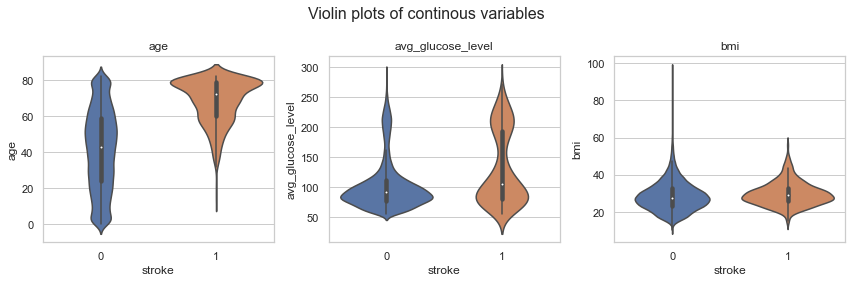

In [83]:
# plot boxplot of all continous columns
fig, axs = plt.subplots(1, 3, figsize=(12,4))
for i, col in enumerate(cont_vars.columns):
    sns.violinplot(ax=axs[i], y=col, x='stroke', data=data)
    axs[i].set_title(col)
fig.suptitle('Violin plots of continous variables', fontsize=16)
plt.tight_layout()
plt.show()

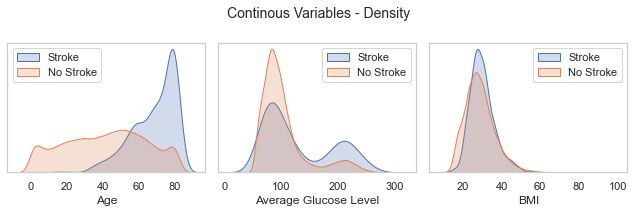

In [84]:
# plot boxplot of all continous columns
data_stroke = data[data['stroke'] == 1]
data_nostroke = data[data['stroke'] == 0]
names = ['Age', 'Average Glucose Level', 'BMI']

fig, axs = plt.subplots(1, 3, figsize=(9,3))
for i, col in enumerate(cont_vars.columns):
    sns.kdeplot(ax=axs[i], x=col, shade=True, data=data_stroke)
    sns.kdeplot(ax=axs[i], x=col, shade=True, data=data_nostroke)
    axs[i].set_ylabel('')
    axs[i].set_yticks([])
    axs[i].set_xlabel(names[i])
    axs[i].grid(False)
# Add legend
axs[0].legend(['Stroke', 'No Stroke'], loc='upper left')
axs[1].legend(['Stroke', 'No Stroke'], loc='upper right')
axs[2].legend(['Stroke', 'No Stroke'], loc='upper right')
fig.suptitle('Continous Variables - Density', fontsize=14)
plt.tight_layout()
plt.savefig('plots/Continous Variables.png')

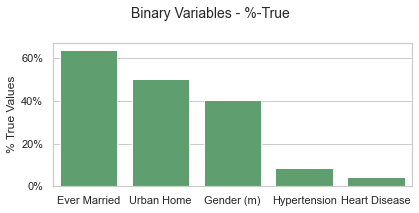

In [85]:
binary_perc = binary_vars.sum()/len(binary_vars)*100
fig = plt.figure(figsize=(6,3))
sns.barplot(x=binary_perc.index, y=binary_perc, color='g')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:}%'.format(int(y))))
plt.ylabel('% True Values')
plt.xticks([0,1,2,3,4], ['Ever Married', 'Urban Home', 'Gender (m)', 'Hypertension', 'Heart Disease'])
plt.suptitle('Binary Variables - %-True', fontsize=14)
plt.tight_layout()
plt.savefig('plots/Binary Variables.png')

In [86]:
binary_vars['stroke'] = data['stroke']
binary_vars_bystroke = binary_vars.groupby('stroke').sum()
binary_perc_bystroke = binary_vars_bystroke
binary_perc_bystroke.iloc[0,:] = binary_perc_bystroke.iloc[0,:]/sum(binary_vars.stroke==0)
binary_perc_bystroke.iloc[1,:] = binary_perc_bystroke.iloc[1,:]/sum(binary_vars.stroke==1)
binary_perc_bystroke = binary_perc_bystroke*100
binary_perc_bystroke = binary_perc_bystroke.round(0).astype(int)
binary_perc_bystroke = binary_perc_bystroke.reset_index()
binary_perc_bystroke

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_20568/108617345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_vars['stroke'] = data['stroke']


,stroke,ever_married,urban_home,gender,hypertension,heart_disease
0,0,64,50,40,9,4
1,1,90,51,44,27,22


In [87]:
bi_melt = pd.melt(binary_perc_bystroke, id_vars='stroke', value_vars=binary_vars_bystroke.columns)
bi_melt

,stroke,variable,value
0,0,ever_married,64
1,1,ever_married,90
2,0,urban_home,50
3,1,urban_home,51
4,0,gender,40
5,1,gender,44
6,0,hypertension,9
7,1,hypertension,27
8,0,heart_disease,4
9,1,heart_disease,22


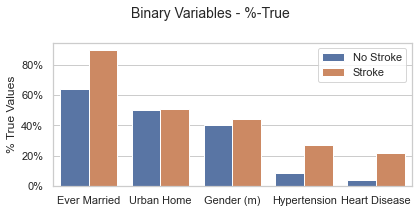

In [88]:
fig = plt.figure(figsize=(6,3))
g = sns.barplot(x=bi_melt.variable, y=bi_melt.value, hue=bi_melt.stroke)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:}%'.format(int(y))))
plt.ylabel('% True Values')
plt.xticks([0,1,2,3,4], ['Ever Married', 'Urban Home', 'Gender (m)', 'Hypertension', 'Heart Disease'])
plt.xlabel('')
plt.suptitle('Binary Variables - %-True', fontsize=14)
leg = g.axes.get_legend()
leg.set_title('')
new_labels = ['No Stroke', 'Stroke']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
plt.tight_layout()
plt.savefig('plots/Binary Variables by stroke.png')

In [89]:
cat_vars.loc[:,'stroke'] = data.stroke

C:\Users\sdien\Anaconda3\envs\ML\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


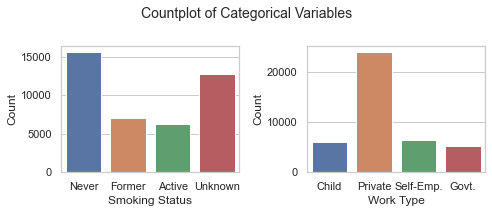

In [90]:
# plot barplot of all categorical columns
fig, axs = plt.subplots(1, 2, figsize=(7,3))
sns.countplot(x='smoking_status', data=cat_vars, ax=axs[0], order=['never', 'former', 'active', 'unknown'])
sns.countplot(x='work_type', data=cat_vars, ax=axs[1])
fig.suptitle('Countplot of Categorical Variables', fontsize=14)
axs[0].set_xlabel('Smoking Status')
axs[0].set_ylabel('Count')
axs[0].set_xticklabels(['Never', 'Former', 'Active', 'Unknown'], rotation=0)
axs[1].set_xlabel('Work Type')
axs[1].set_ylabel('Count')
axs[1].set_xticklabels(['Child', 'Private', 'Self-Emp.', 'Govt.'], rotation=0)
plt.tight_layout()
plt.savefig('plots/Categorical Variables.png')

In [91]:
smoke_perc = cat_vars.groupby(['stroke', 'smoking_status']).count().reset_index()
smoke_perc = smoke_perc.rename(columns={'work_type':'count_n'})
smoke_perc.loc[smoke_perc.stroke==0, 'count_n'] = smoke_perc.count_n/sum(smoke_perc.loc[smoke_perc.stroke==0, 'count_n'])
smoke_perc.loc[smoke_perc.stroke==1, 'count_n'] = smoke_perc.count_n/sum(smoke_perc.loc[smoke_perc.stroke==1, 'count_n'])

In [92]:
work_perc = cat_vars.groupby(['stroke', 'work_type']).count().reset_index()
work_perc = work_perc.rename(columns={'smoking_status':'count_n'})
work_perc.loc[work_perc.stroke==0, 'count_n'] = work_perc.count_n/sum(work_perc.loc[work_perc.stroke==0, 'count_n'])
work_perc.loc[work_perc.stroke==1, 'count_n'] = work_perc.count_n/sum(work_perc.loc[work_perc.stroke==1, 'count_n'])

In [93]:
data.work_type.value_counts()

private     23980
self_emp     6474
child        6058
govt         5243
Name: work_type, dtype: int64

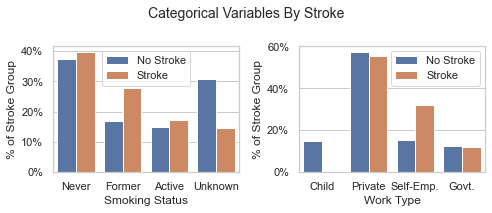

In [94]:
# plot barplot of categorical columns by stroke
fig, axs = plt.subplots(1, 2, figsize=(7,3))
sns.barplot(x='smoking_status', y='count_n', hue='stroke', ax=axs[0], order=['never', 'former', 'active', 'unknown'], data=smoke_perc)
sns.barplot(x='work_type', y='count_n', hue='stroke', ax=axs[1], order=['child', 'private', 'self_emp', 'govt'], data=work_perc)
fig.suptitle('Categorical Variables By Stroke', fontsize=14)
axs[0].set_xlabel('Smoking Status')
axs[0].set_ylabel('% of Stroke Group')
axs[0].set_xticklabels(['Never', 'Former', 'Active', 'Unknown'], rotation=0)
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:}%'.format(int(y*100))))
leg = axs[0].get_legend()
leg.set_title('')
new_labels = ['No Stroke', 'Stroke']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
axs[1].set_xlabel('Work Type')
axs[1].set_ylabel('% of Stroke Group')
axs[1].set_xticklabels(['Child', 'Private', 'Self-Emp.', 'Govt.'], rotation=0)
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:}%'.format(int(y*100))))
leg = axs[1].get_legend()
leg.set_title('')
new_labels = ['No Stroke', 'Stroke']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
plt.tight_layout()
plt.savefig('plots/Categorical Variables By Stroke.png')

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_20568/2812790012.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


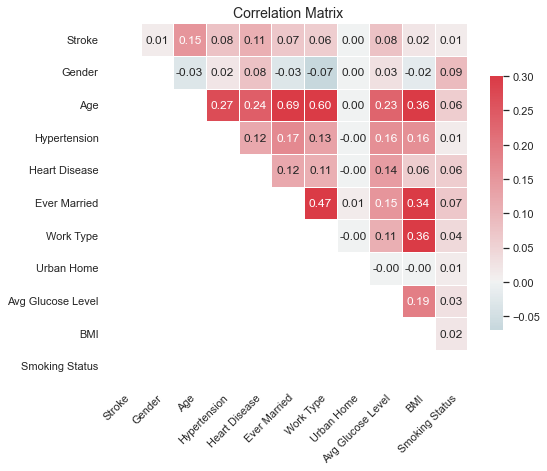

In [95]:
# Create numeric correlation matrix
corr_data = data.copy()
corr_data.smoking_status = corr_data.smoking_status.map(  # quantize smoking status
    {'never': 0, 'former': 1, 'active': 2, 'unknown': np.nan})
corr_data.work_type = corr_data.work_type.map(  # quantize work type
    {'child': 0, 'govt': 1, 'private': 2, 'self_emp': 3})

# Rename columns
corr_data.columns = ['Stroke', 'Gender', 'Age', 'Hypertension', 'Heart Disease', 'Ever Married', 'Work Type',
                     'Urban Home', 'Avg Glucose Level', 'BMI', 'Smoking Status']

                    

corr = corr_data.corr().round(2)

# Generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Plot as heatmap
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title('Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.savefig('plots/Correlation Matrix.png', )

In [96]:
data.describe().loc[['min', 'mean', 'max', 'std'],:].round(2).T

,min,mean,max,std
stroke,0.00,0.02,1.00,0.12
gender,0.00,0.40,1.00,0.49
age,0.08,41.94,82.00,22.47
hypertension,0.00,0.09,1.00,0.28
heart_disease,0.00,0.04,1.00,0.20
ever_married,0.00,0.64,1.00,0.48
urban_home,0.00,0.50,1.00,0.50
avg_glucose_level,55.00,103.67,291.05,42.28
bmi,10.10,28.62,97.60,7.77
